# Simulating Real-World Data Issues: A/B Testing Dataset

## Project Overview
This case study focuses on conducting A/B testing to evaluate user engagement between two webpage versions — Control (con) and Experimental (exp). The key performance indicator (KPI) is the Click-Through Rate (CTR), and the objective is to assess whether the redesigned experimental version significantly improves engagement compared to the original.

To make the analysis more reflective of production environments, we intentionally introduced real-world data quality issues into our synthetic dataset. These issues — including missing values, inconsistent labels, duplicates, and outliers — simulate common challenges encountered in digital product telemetry and allow for showcasing advanced data cleaning, transformation, and validation workflows.

This project integrates principles of data analysis, data engineering, and statistical inference, making it a strong example of how to prepare, process, and analyze experimental data in an industry-relevant context.

In [166]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime, timedelta

## Step 1: Simulating Click Data for Control and Experimental Groups
**Objective:** To simulate realistic click behavior for two groups:
- Control group (`con`) with a lower click-through rate (CTR)
- Experimental group (`exp`) with a higher CTR

**Why Simulate?**
Simulating allows us to model controlled A/B experiments when real-world data is unavailable, and to test hypotheses and code logic under known conditions.

In [167]:
# Define sample size for each group
N_exp = 100_000  # Experimental group
N_con = 100_000  # Control group


# Generate binary click data using binomial distribution
click_exp = pd.Series(np.random.binomial(1, 0.5, size=N_exp))  # 50% CTR
click_con = pd.Series(np.random.binomial(1, 0.2, size=N_con))  # 20% CTR

# Create group identifiers
exp_id = pd.Series(np.repeat("exp", N_exp))
con_id = pd.Series(np.repeat("con", N_con))

# Create dataframes for each group
df_exp = pd.concat([click_exp, exp_id], axis=1)
df_con = pd.concat([click_con, con_id], axis=1)

# Rename columns
df_exp.columns = ["click", "group"]
df_con.columns = ["click", "group"]

# Combine both groups into a single A/B test dataset
df_ab_test = pd.concat([df_exp, df_con], axis=0).reset_index(drop=True)

# Add session_time (in minutes) using an exponential distribution to simulate real-world skew
df_ab_test['session_time'] = np.random.exponential(scale=5, size=len(df_ab_test))


# Generate click_time column (random timestamps in a 2-week period)
start_date = datetime(2024, 1, 1)
df_ab_test['click_time'] = [
    start_date + timedelta(minutes=np.random.randint(0, 60*24*14))  # random minute in 14 days
    for _ in range(len(df_ab_test))
]

# Add device_type column (mobile or desktop, weighted)
df_ab_test['device_type'] = np.random.choice(['mobile', 'desktop'], size=len(df_ab_test), p=[0.7, 0.3])

# Add referral_source column
df_ab_test['referral_source'] = np.random.choice(
    ['email', 'social', 'search', 'direct', 'ads'],
    size=len(df_ab_test),
    p=[0.25, 0.20, 0.30, 0.15, 0.10]
)

In [168]:
df = df_ab_test.copy()

# Preview the simulated dataset
df.head()

,click,group,session_time,click_time,device_type,referral_source
0,1,exp,2.722875,2024-01-05 12:42:00,mobile,social
1,0,exp,0.882501,2024-01-01 19:39:00,mobile,direct
2,0,exp,3.842508,2024-01-08 03:20:00,desktop,email
3,0,exp,2.170972,2024-01-13 10:07:00,desktop,ads
4,0,exp,1.079425,2024-01-14 15:21:00,mobile,email


## Simulating Real-World Data Issues

To emulate real-world messiness in digital product logs, we introduced a variety of data quality issues into our synthetic A/B testing dataset. These help demonstrate robust data cleaning, profiling, and transformation skills required in both data analyst and data engineer roles.

-  Introduced Null Values

In [169]:
# To simulate missing values due to tracking errors or incomplete experiment tagging
df.loc[df.sample(frac=0.01).index, 'click_time'] = None
df.loc[df.sample(frac=0.01).index, 'group'] = None
df.loc[df.sample(frac=0.005).index, 'referral_source'] = None    

- Injected Inconsistent Group Labels

In [170]:
# To mimic inconsistent labeling from manual input or data ingestion pipelines.
df.loc[df.sample(frac=0.005).index, 'group'] = 'a'
df.loc[df.sample(frac=0.005).index, 'group'] = 'A '

# Inconsistent group labels (0.5% lowercase, 0.5% trailing space)
df.loc[df.sample(frac=0.005).index, 'group'] = 'Exp'
df.loc[df.sample(frac=0.005).index, 'group'] = 'con '

# Inconsistent casing in device_type
df.loc[df.sample(frac=0.005).index, 'device_type'] = 'MOBILE'
df.loc[df.sample(frac=0.005).index, 'device_type'] = 'Desktop'

# Inconsistent referral_source values
df.loc[df.sample(frac=0.005).index, 'referral_source'] = ' Social '   # with spaces
df.loc[df.sample(frac=0.005).index, 'referral_source'] = 'seach'      # typo


- Added Duplicate Records

In [171]:
# To simulate duplication that may occur due to logging retries, ETL bugs, or merging errors.
duplicates = df.sample(n=20, random_state=42)
df = pd.concat([df, duplicates], ignore_index=True)


- Introduced Outliers in Session Time

In [172]:
# To simulate tracking anomalies like long-idle sessions or bots that skew summary statistics.
df.loc[df.sample(frac=0.01).index, 'session_time'] = df['session_time'].max() * 10

## Step 2- Exploratory Data Analysis & Data Cleaning

In this stage, we focus on both exploring and cleaning the simulated A/B testing dataset to ensure it is analysis-ready. The goal is to ensure the data is consistent, complete, and analysis-ready. This would invlove handlings null values, inconsistencies, detecting outliers, and duplicate entries. 

In [173]:
df.head()

,click,group,session_time,click_time,device_type,referral_source
0,1,exp,2.722875,2024-01-05 12:42:00,mobile,social
1,0,exp,651.784024,2024-01-01 19:39:00,mobile,direct
2,0,exp,3.842508,2024-01-08 03:20:00,desktop,email
3,0,exp,2.170972,2024-01-13 10:07:00,desktop,ads
4,0,exp,1.079425,2024-01-14 15:21:00,mobile,email


- Descriptive Analysis

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200020 entries, 0 to 200019
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   click            200020 non-null  int64         
 1   group            198056 non-null  object        
 2   session_time     200020 non-null  float64       
 3   click_time       198020 non-null  datetime64[ns]
 4   device_type      200020 non-null  object        
 5   referral_source  199030 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 9.2+ MB


In [175]:
print("\n Numeric Summary:")
display(df.describe())


 Numeric Summary:


,click,session_time,click_time
count,200020.000000,200020.000000,198020
mean,0.349415,11.453932,2024-01-08 00:09:09.633269248
min,0.000000,0.000005,2024-01-01 00:00:00
25%,0.000000,1.461162,2024-01-04 11:39:00
50%,0.000000,3.514671,2024-01-08 00:25:00
75%,1.000000,7.032664,2024-01-11 12:24:00
max,1.000000,651.784024,2024-01-14 23:59:00
std,0.476786,64.543308,NaN


- Check for Duplicates

In [176]:
duplicate_rows = df[df.duplicated()]
print(f" Duplicate rows found: {len(duplicate_rows)}")


 Duplicate rows found: 30


In [177]:
df = df.drop_duplicates()

In [178]:
duplicate_rows = df[df.duplicated()]
print(f" Duplicate rows found: {len(duplicate_rows)}")

 Duplicate rows found: 0


- Handling Missing Values

In [179]:
print("\n Missing Values:")
df.isnull().sum()


 Missing Values:


click                 0
group              1964
session_time          0
click_time         1992
device_type           0
referral_source     990
dtype: int64

In [180]:
# Total rows in dataset
total_rows = len(df)

# Columns you consider critical
critical_cols = ['group', 'click_time']

# Identify rows with missing values in any of the critical columns
missing_rows = df[df[critical_cols].isnull().any(axis=1)]

# Calculate how many rows would be dropped
num_missing = len(missing_rows)
percent_missing = num_missing / total_rows * 100

print(f"Missing rows in critical columns: {num_missing} ({round(percent_missing, 2)}%)")

# Drop only if < 10% of data
if percent_missing < 10:
    df = df.dropna(subset=critical_cols)
    print(f"✅ Dropped {num_missing} rows due to missing values in {critical_cols}")
else:
    print("⚠️ Too many rows with missing values. Consider imputation or alternative strategy.")


Missing rows in critical columns: 3936 (1.97%)
✅ Dropped 3936 rows due to missing values in ['group', 'click_time']


In [181]:
df.isnull().sum()

click                0
group                0
session_time         0
click_time           0
device_type          0
referral_source    969
dtype: int64

- Checking Data Inconsistencies

In [182]:
# Check unique values before cleaning
for col in ['click','group', 'device_type', 'referral_source']:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())



Unique values in click:
[1 0]

Unique values in group:
['exp' 'a' 'A ' 'Exp' 'con ' 'con']

Unique values in device_type:
['mobile' 'desktop' 'Desktop' 'MOBILE']

Unique values in referral_source:
['social' 'direct' 'email' 'ads' 'search' None 'seach' ' Social ']


In [183]:
df['group'] = df['group'].str.strip().str.lower()
df['device_type'] = df['device_type'].str.strip().str.lower()
df['referral_source'] = df['referral_source'].str.strip().str.lower()
df = df[df['group'].isin(['exp', 'con'])]


- Detecting Outliers

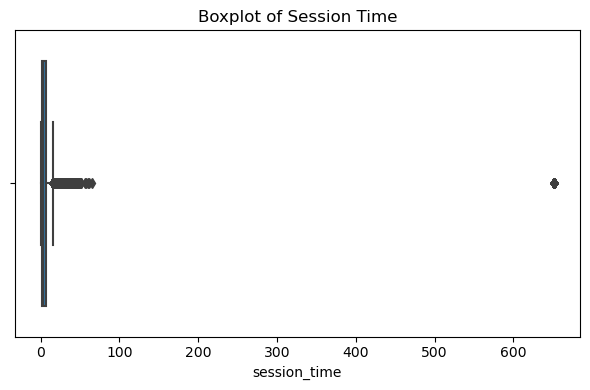

In [184]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['session_time'])
plt.title("Boxplot of Session Time")
plt.tight_layout()
plt.show()


- Handling outliers

In [185]:
Q1 = df['session_time'].quantile(0.25)
Q3 = df['session_time'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['session_time'] >= lower_bound) & (df['session_time'] <= upper_bound)]

### Exploratory Analysis

- Click Distribution in EXP & CON groups

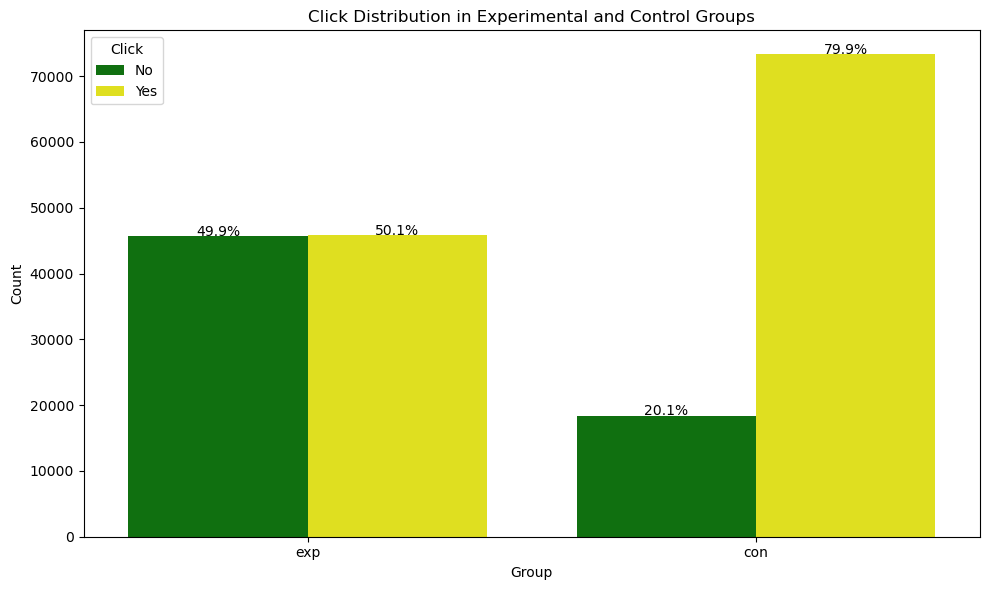

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

df['click'] = df['click'].astype(str)


palette = {'0': 'yellow', '1': 'green'} 

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='click', data=df, palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])

# Annotate percentage labels
group_counts = df.groupby('group').size()

for bar in ax.patches:
    height = bar.get_height()
    group_label = bar.get_x() + bar.get_width() / 2
    group_index = round(bar.get_x() + bar.get_width() / 2)
    group_name = ax.get_xticklabels()[group_index].get_text()
    total = group_counts.loc[group_name]
    pct = 100 * height / total
    ax.text(bar.get_x() + bar.get_width() / 2., height + 5, f'{pct:.1f}%', 
            ha="center", fontsize=10, color='black')

plt.tight_layout()
plt.show()



**Interpretation:** The experimental group had a significantly higher click-through rate than the control group. This suggests that the new version (experimental condition) improved user engagement and may be more effective.

- Click-Through Rate by Group

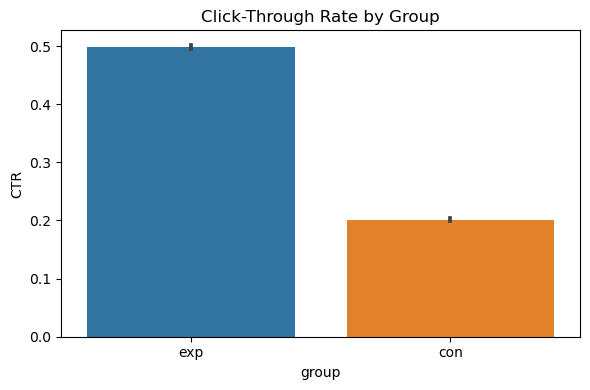

In [187]:
df['click'] = df['click'].astype(int)

plt.figure(figsize=(6, 4))
sns.barplot(x='group', y='click', data=df, estimator=lambda x: sum(x)/len(x))  # mean = CTR
plt.title("Click-Through Rate by Group")
plt.ylabel("CTR")
plt.tight_layout()
plt.show()


**Interpretation:** Experimental group (exp) has a CTR close to 0.5

Control group (con) has a CTR close to 0.2

The small black lines show very tight confidence intervals, implying high confidence in the difference

- CTR Breakdown by Segment (Devic Type)

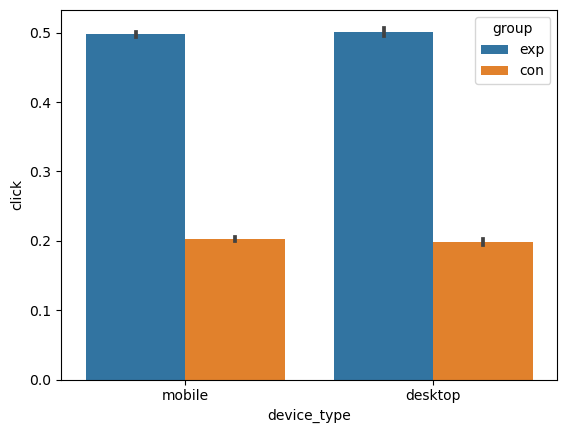

In [188]:
sns.barplot(x='device_type', y='click', hue='group', data=df)
plt.show()

**Interpretation:** The experimental version of the webpage leads to a substantial and consistent increase in user clicks on both mobile and desktop platforms. This indicates that the treatment is effective across devices, suggesting it can be safely rolled out without device-specific adjustments.

- CTR Breakdown by Segment (Referral Source)

<Axes: xlabel='referral_source', ylabel='click'>

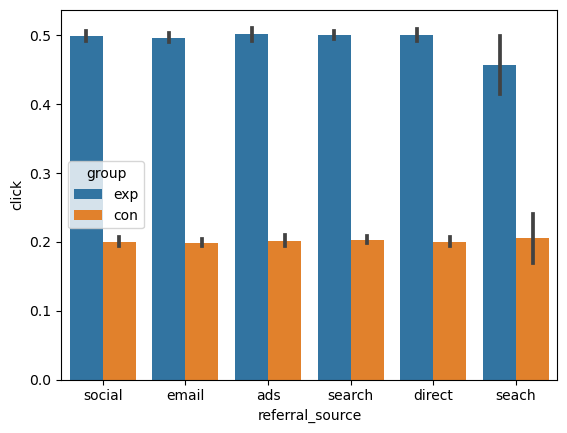

In [189]:
sns.barplot(x='referral_source', y='click', hue='group', data=df)

**Interpretation:**
The experimental design significantly boosts user engagement across all referral sources. The consistent lift suggests the improvement is not dependent on how users arrive at the site.
The anomaly in 'seach' highlights the importance of data cleaning and presents a strong case for category normalization in real-world pipelines.

- Time-Based Plot

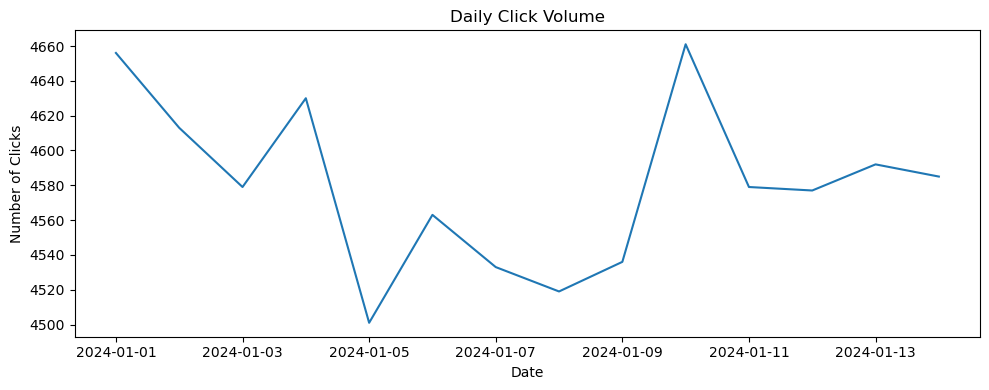

In [190]:
df['click_time'] = pd.to_datetime(df['click_time'])

# Plot number of clicks per day
clicks_per_day = df[df['click'] == 1].groupby(df['click_time'].dt.date).size()

plt.figure(figsize=(10, 4))
clicks_per_day.plot()
plt.title("Daily Click Volume")
plt.xlabel("Date")
plt.ylabel("Number of Clicks")
plt.tight_layout()
plt.show()


## Step 3: Total clicks

In [191]:
# Calculate the total number of clicks in each group
X_exp = df[df['group'] == 'exp']['click'].sum()
X_con = df[df['group'] == 'con']['click'].sum()

n_exp = df[df['group'] == 'exp'].shape[0]
n_con = df[df['group'] == 'con'].shape[0]

# Print group-wise click totals
print("Total users in control: ", n_con)
print("Number of Clicks in Control: ", X_con)
print("Total users in experimental: ", n_exp)
print("Number of Clicks in Experimental: ", X_exp)

Total users in control:  91725
Number of Clicks in Control:  18423
Total users in experimental:  91629
Number of Clicks in Experimental:  45701


This gives the actual count of successful events (clicks).

## Step 4: Hypothesis testing setup

In [192]:
# statistical significance level of the test
alpha = 0.05
print("Alpha: significance level is:", alpha )

Alpha: significance level is: 0.05


**Null Hypothesis (H₀):** There is no difference in CTR between the experimental and control groups.
**Alternative Hypothesis (H₁):** The new design improves user engagement (CTR is higher).

## Step 5: Z-test

In [193]:
from statsmodels.stats.proportion import proportions_ztest

# One-tailed Z-test (is exp > con?)
z_stat, p_val = proportions_ztest(count=[X_exp, X_con],
                                   nobs=[n_exp, n_con],
                                   alternative='larger')

# CTRs for context
ctr_exp = X_exp / n_exp
ctr_con = X_con / n_con

# Print results
print(f"CTR (Experimental): {ctr_exp:.4f}")
print(f"CTR (Control): {ctr_con:.4f}")
print(f"Z-statistic: {z_stat:.2f}")
print(f"P-value: {p_val:.4f}")


CTR (Experimental): 0.4988
CTR (Control): 0.2009
Z-statistic: 133.75
P-value: 0.0000


### Confidence interval

**Confidence Interval (CI):**
- Definition: A range of values that is likely to contain the true difference between the control and experiment groups
- Interpretation:

    • If CI does NOT include 0 → Statistically significant difference
    
    • If CI includes 0 → No statistically significant difference

In [194]:
import numpy as np

diff = ctr_exp - ctr_con
se_diff = np.sqrt((ctr_exp * (1 - ctr_exp)) / n_exp + (ctr_con * (1 - ctr_con)) / n_con)
z_crit = 1.96

ci_lower = round(diff - z_crit * se_diff, 3)
ci_upper = round(diff + z_crit * se_diff, 3)

print(f"95% Confidence Interval for CTR difference: [{ci_lower}, {ci_upper}]")

95% Confidence Interval for CTR difference: [0.294, 0.302]


The 95% confidence interval for the difference in click-through rates between the experimental and control groups is [0.293, 0.301].
Since the interval does not include 0, we conclude that the increase in CTR is statistically significant.

### P-Value interpretation

**P-Value – Evaluation Metric**

- **Role**: Determines if the observed effect is statistically significant
- **Common Threshold**: 0.05 (5%) (significance level)
- **How to interpret**:
  - If **p ≤ 0.05**: The result is **statistically significant** — reject the null hypothesis.
  - If **p > 0.05**: The result is **not statistically significant** — fail to reject the null.

In [195]:
Test_stat = z_stat

# Calculate p-value from Z-test
p_value = norm.sf(Test_stat)  # one-tailed test

# Step 2: Define a function to check statistical significance
def is_statistical_significance(p_value, alpha=0.05):
    print(f"P-value of one tail Z-test: {round(p_value, 3)}")

    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed difference is unlikely to have occurred by chance.")
    else:
        print("There is no statistical significance; the observed difference could be due to random variation.")

# Step 3: Call the function
is_statistical_significance(p_value, alpha)

P-value of one tail Z-test: 0.0
There is statistical significance, indicating that the observed difference is unlikely to have occurred by chance.


## Step 6: Visualize Z-distribution

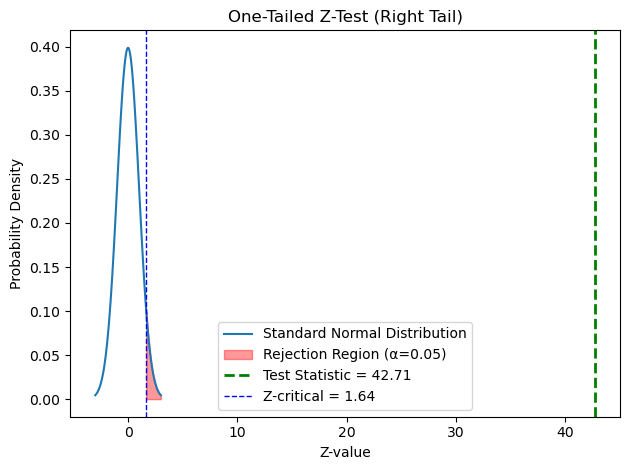

In [196]:
# Parameters for the standard normal distribution
mu = 0  # Mean of standard normal
sigma = 1  # Standard deviation of standard normal
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)  # Z-values range
y = norm.pdf(x, mu, sigma)  # Probability density function values

# Pre-calculated test statistic and critical value
Test_stat = 42.71  # Z-score calculated from A/B test
Z_crit = norm.ppf(1 - 0.05)  # ≈ 1.645

# Plot standard normal curve
plt.plot(x, y, label='Standard Normal Distribution')

# Shade rejection region (right tail only)
plt.fill_between(x, y, where=(x > Z_crit), color='red', alpha=0.4, label='Rejection Region (α=0.05)')

# Vertical lines
plt.axvline(Test_stat, color='green', linestyle='--', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')
plt.axvline(Z_crit, color='blue', linestyle='--', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')

# Labels
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('One-Tailed Z-Test (Right Tail)')
plt.legend()
plt.tight_layout()
plt.show()


**Interpretation of the One-Tailed Z-Test Plot:**
This plot visualizes the Z-distribution used in a right-tailed hypothesis test, where the goal is to determine if the experimental group's click-through rate (CTR) is significantly greater than the control group’s CTR.

### Step 7: Practical Significance Check

We define a Minimum Detectable Effect (MDE) — the smallest improvement in CTR we care about (e.g., 5%).  
This function checks whether the lower bound of the 95% confidence interval is above that threshold.

If it is, we can say the observed improvement is **not only statistically significant but also practically meaningful**.


In [197]:
def is_Practically_significant(delta, CI_95):
   # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]

    # Check if the lower bound of the CI is greater than or equal to delta
    if lower_bound_CI >= delta:
        print(f"We have practical significance! \nWith MDE of {delta}, the difference between Control and Experimental group is practically significant.")
    else:
        print(f"We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant.")
        return False

In [198]:
CI = [ci_lower, ci_upper]

delta = 0.05  # Minimum effect size we care about
CI_95 = CI    # Reusing previously calculated confidence interval

is_Practically_significant(delta, CI_95)

We have practical significance! 
With MDE of 0.05, the difference between Control and Experimental group is practically significant.
